In [1]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings as w
w.filterwarnings('ignore')
import scipy as sp
import os
import flask as f
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.applications import DenseNet121 as DN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

2025-09-07 13:02:29.386177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757250149.739468      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757250149.840336      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SIZE = (512,512)
BATCH_SIZE = 16

In [3]:
#considerig the training and testing sets
train_set = '/kaggle/input/final-dataset/dataset/Training'
test_set = '/kaggle/input/final-dataset/dataset/Testing'

In [4]:
#image augumentation and normalization for the training set, and rescaling the testing set
train_datagen = IDG(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.20,
    height_shift_range = 0.20,
    shear_range = 0.15,
    zoom_range = 0.20,
    brightness_range = [0.6,1.4],
    channel_shift_range = 20.0,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.1
)

test_val_datagen = IDG(
    rescale = 1./255
)

In [5]:
#loading the training, testing and validation data

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/final-dataset/dataset/Training',
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True
)

val_generator = test_val_datagen.flow_from_directory(
    '/kaggle/input/final-dataset/dataset/Validation',
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False
)

test_generator = test_val_datagen.flow_from_directory(
    '/kaggle/input/final-dataset/dataset/Testing',
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False
)

Found 5143 images belonging to 4 classes.
Found 569 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


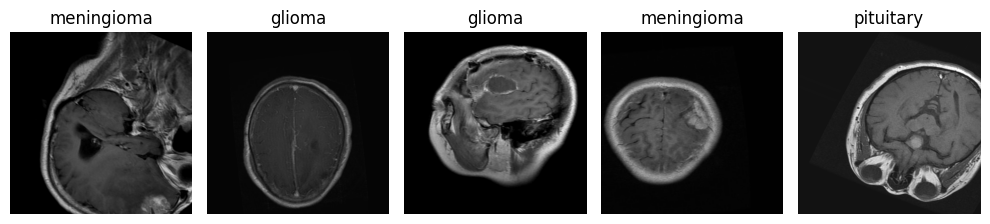

In [6]:
#preview of our preprocessed images
# Show 5 sample preprocessed training images
class_labels = list(train_generator.class_indices.keys())
images, labels = next(train_generator)

plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    plt.title(class_labels[label_index])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
from sklearn.utils import class_weight
import numpy as np

train_labels = train_generator.classes

classWeights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
classWeights = dict(enumerate(classWeights))

In [8]:
#introducing the callbacks to prevent either overfitting or underfitting
from tensorflow.keras.callbacks import EarlyStopping as ES
from tensorflow.keras.callbacks import ModelCheckpoint as MC
from tensorflow.keras.callbacks import ReduceLROnPlateau as LRP

check_point = MC(
    "DN_Model.keras",
    monitor = "val_accuracy",
    save_best_only = True,
    mode = "max",
    verbose = 1
)

early_stop = ES(
    monitor = "val_loss",
    patience = 8,
    restore_best_weights = True
)

reduce_LR = LRP(
    monitor = 'val_accuracy',
    factor = 0.5,
    patience = 3,
    verbose = 1
)

In [10]:
w.filterwarnings('ignore')
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy as CCE

built_model = DN(
    weights = 'imagenet',
    include_top = False,
    input_shape = (512,512,3)
)
built_model.trainable = False

x = built_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.5)(x)
op = Dense(4,activation='softmax', dtype='float32')(x)

#final model
DNModel = Model(inputs=built_model.input, outputs=op)

# Unfreeze last 40 layers
for layer in built_model.layers[-40:]:
    layer.trainable = True

#compiling with adanW optimizer
adamw = AdamW(
    learning_rate = 1e-4,
    weight_decay = 1e-5
)

#compiling the model
DNModel.compile(
    optimizer = adamw,
    loss = CCE(label_smoothing = 0.1),        #reduces the overconfidence
    metrics = ['accuracy']
)

I0000 00:00:1757250951.872827      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757250951.873614      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
w.filterwarnings('ignore')
history = DNModel.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 40,
    callbacks = [early_stop, check_point,reduce_LR],
    class_weight = classWeights
)

Epoch 1/40


I0000 00:00:1757251138.764287     135 service.cc:148] XLA service 0x79f4f4221620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757251138.765890     135 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757251138.765912     135 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757251142.607878     135 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757251167.790111     135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4593 - loss: 1.3496
Epoch 1: val_accuracy improved from -inf to 0.87522, saving model to DN_Model.keras
322/322 ━━━━━━━━━━━━━━━━━━━━ 516s 1s/step - accuracy: 0.4598 - loss: 1.3487 - val_accuracy: 0.8752 - val_loss: 0.6530 - learning_rate: 1.0000e-04
Epoch 2/40
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8005 - loss: 0.7702
Epoch 2: val_accuracy improved from 0.87522 to 0.89807, saving model to DN_Model.keras
322/322 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.8006 - loss: 0.7701 - val_accuracy: 0.8981 - val_loss: 0.5831 - learning_rate: 1.0000e-04
Epoch 3/40
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8630 - loss: 0.6702
Epoch 3: val_accuracy improved from 0.89807 to 0.91564, saving model to DN_Model.keras
322/322 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.8630 - loss: 0.6702 - val_accuracy: 0.9156 - val_loss: 0.5382 - learning_rate: 1.0000e-04
Epoch 4/40
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accurac

In [13]:
 # Evaluation on test data
loss, accuracy = DNModel.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 490ms/step - accuracy: 0.9899 - loss: 0.3801
Test Accuracy: 99.31%


In [14]:
import numpy as np
# True labels from the generator
y_true = test_generator.classes

# Class index to label mapping
class_labels = list(test_generator.class_indices.keys())

# Get predictions (probabilities)
y_pred_probs = DNModel.predict(test_generator, verbose=1)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 38s 324ms/step


In [15]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

# Get true labels and predictions
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Predict
pred_probs = DNModel.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Reds', xticks_rotation=45)
plt.title("Confusion Matrix\n")
plt.show()

# Classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("\nClassification Report:\n")
print(report)

82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step



Classification Report:

              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.98      0.99      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [16]:
w.filterwarnings('ignore')
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load your trained model
finModel = load_model('DN_Model.keras')  # change to your actual model path

In [17]:
def preprocess_image(img_path):
    # Load image
    img = image.load_img(img_path, target_size=IMG_SIZE)

    # Convert to array
    img_array = image.img_to_array(img)

    # Rescale pixel values
    img_array = img_array / 255.0

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

In [18]:
# Get class labels (same order as in training)
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

def predict_tumor(img_path):
    preprocessed_img = preprocess_image(img_path)
    prediction = finModel.predict(preprocessed_img)
    class_index = np.argmax(prediction, axis=1)[0]
    predicted_class = class_labels[class_index]

    # Display
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()
    print(f"Predicted Tumor Type: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


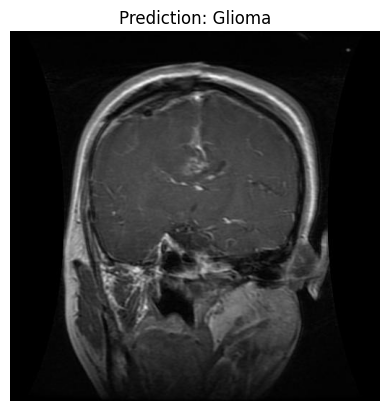

Predicted Tumor Type: Glioma


In [19]:
#testing the model with the random inputs
imgPath1 = '/kaggle/input/final-dataset/dataset/Testing/glioma/Te-gl_0058.jpg'
predict_tumor(imgPath1)

In [20]:
imgPath2= '/kaggle/input/final-dataset/dataset/Testing/meningioma/Te-meTr_0000.jpg'
predict_tumor(imgPath2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Predicted Tumor Type: Meningioma


In [22]:
imgPath3= '/kaggle/input/final-dataset/dataset/Testing/notumor/Te-no_0088.jpg'
predict_tumor(imgPath3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Predicted Tumor Type: No Tumor


In [23]:
imgPath4= '/kaggle/input/final-dataset/dataset/Testing/pituitary/Te-pi_0027.jpg'
predict_tumor(imgPath4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Predicted Tumor Type: Pituitary


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


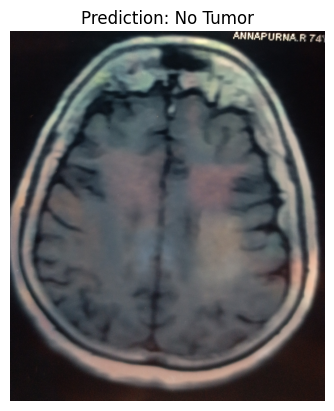

Predicted Tumor Type: No Tumor


In [24]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan1.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


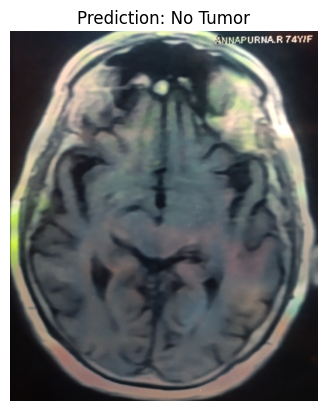

Predicted Tumor Type: No Tumor


In [25]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan2.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


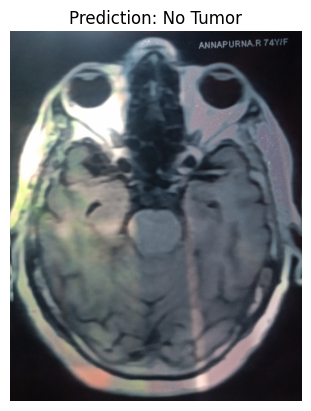

Predicted Tumor Type: No Tumor


In [26]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan3.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


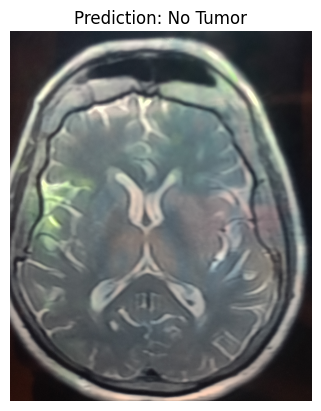

Predicted Tumor Type: No Tumor


In [27]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan4.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


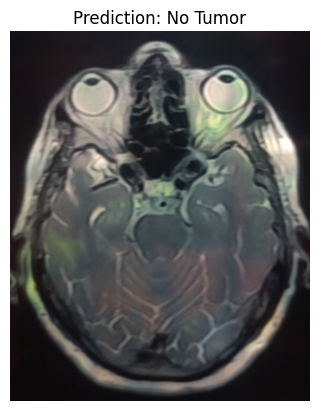

Predicted Tumor Type: No Tumor


In [28]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan5.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


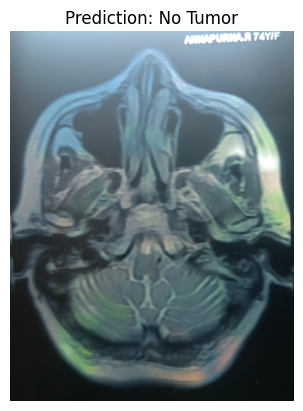

Predicted Tumor Type: No Tumor


In [29]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan6.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


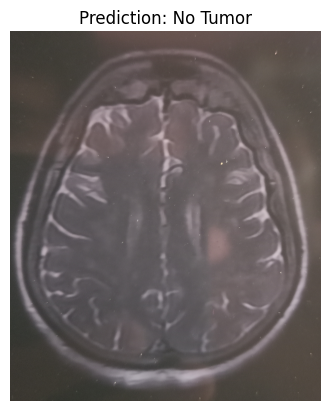

Predicted Tumor Type: No Tumor


In [30]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan7.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


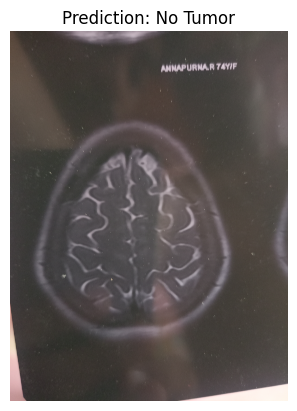

Predicted Tumor Type: No Tumor


In [31]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan8.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


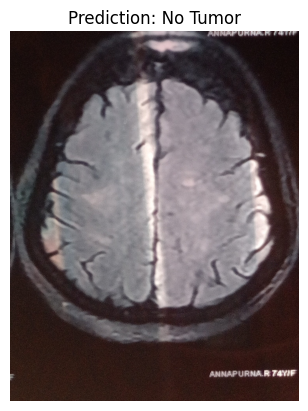

Predicted Tumor Type: No Tumor


In [32]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan9.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


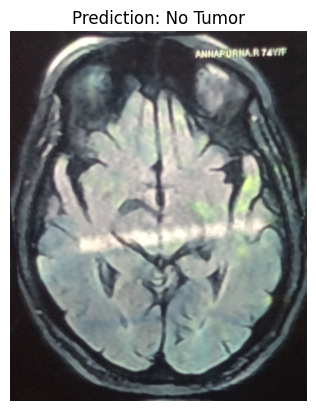

Predicted Tumor Type: No Tumor


In [33]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan10.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


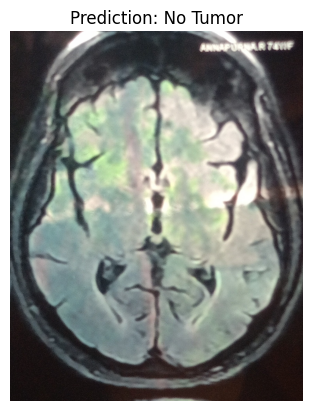

Predicted Tumor Type: No Tumor


In [34]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan11.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


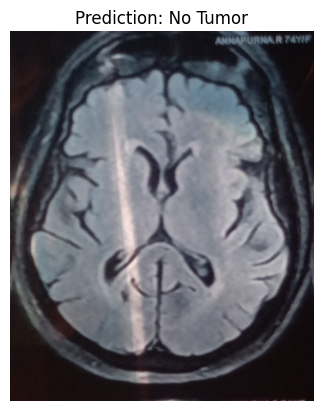

Predicted Tumor Type: No Tumor


In [35]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan12.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


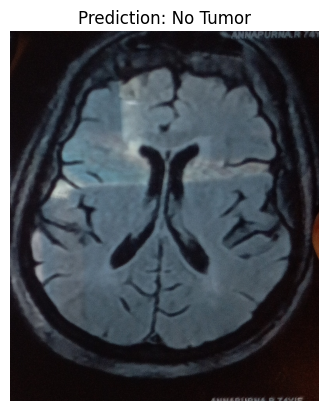

Predicted Tumor Type: No Tumor


In [36]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan13.jpg'
predict_tumor(imgPath5)

In [37]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan14.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Predicted Tumor Type: No Tumor


In [38]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan15.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Predicted Tumor Type: No Tumor


In [39]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan16.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Predicted Tumor Type: No Tumor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


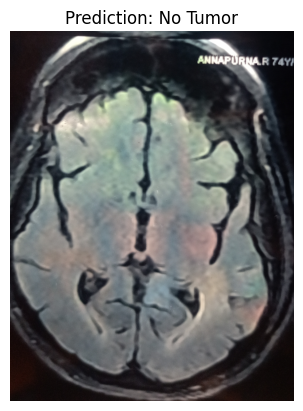

Predicted Tumor Type: No Tumor


In [40]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan17.jpg'
predict_tumor(imgPath5)

In [41]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan18.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Predicted Tumor Type: No Tumor


In [42]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan19.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Predicted Tumor Type: Meningioma


In [43]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan20.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Predicted Tumor Type: No Tumor


In [44]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan21.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Predicted Tumor Type: No Tumor


In [45]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan22.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Predicted Tumor Type: No Tumor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


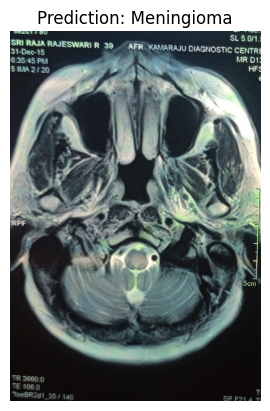

Predicted Tumor Type: Meningioma


In [46]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan23.jpg'
predict_tumor(imgPath5)

In [47]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan24.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Predicted Tumor Type: Meningioma


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


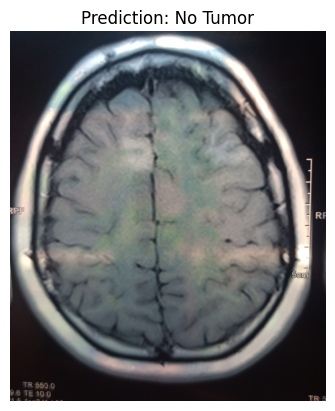

Predicted Tumor Type: No Tumor


In [48]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan25.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


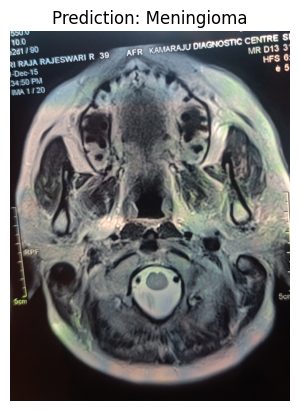

Predicted Tumor Type: Meningioma


In [49]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan26.jpg'
predict_tumor(imgPath5)

In [50]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan27.jpg'
predict_tumor(imgPath5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Predicted Tumor Type: No Tumor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


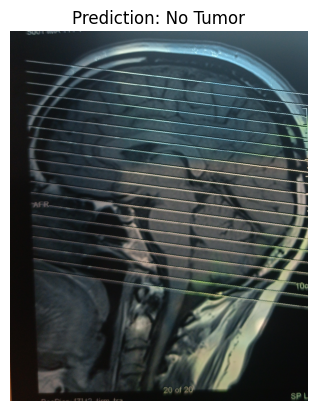

Predicted Tumor Type: No Tumor


In [51]:
imgPath5= '/kaggle/input/new-inputs/Brain New MRI images/scan28.jpg'
predict_tumor(imgPath5)